In [1]:
import collections
import json
import datetime

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
with open("data/results/all_imports.json") as handle:
    libs_data = [json.loads(row) for row in handle]

with open("/home/jegkocka88/CCL/SO_Post_Analyzer/data/results/new_first_indiv.json") as handle:
    indiv_raw = json.load(handle)
    indiv = {k: datetime.datetime.strptime(v, '%Y-%m-%d') for k, v in indiv_raw.items()}

with open("/home/jegkocka88/CCL/SO_Post_Analyzer/data/results/new_first_pairs.json") as handle:
    pair_raw = json.load(handle)
    pair = {k: datetime.datetime.strptime(v, '%Y-%m-%d') for k, v in pair_raw.items()}

In [6]:
libs_by_count = collections.Counter([item for row in libs_data for item in row.get('imports')])

most_common_cut = 1_000

print(f"We have {len(libs_by_count)} libraries listed. They form {len(pair)} pairs")
print(f"Only considering the top {most_common_cut} libraries for filtered results.")
most_common = set([item[0] for item in libs_by_count.most_common(most_common_cut)])

indiv_filtered = {k: v for k, v in indiv.items() if k in most_common}
pair_filtered = {k: v for k, v in pair.items() if all([part in most_common for part in k.split("|")])}
print(f"We kept {len(indiv_filtered)} individual libs and {len(pair_filtered)} pairs.")

We have 16239 libraries listed. They form 143913 pairs
Only considering the top 1000 libraries for filtered results.
We kept 1000 individual libs and 63555 pairs.


In [10]:
bin_cnt = 10_000

In [11]:
df_indiv['bin'] = pd.cut(df_indiv.appearance_date, bins=bin_cnt)
df_indiv["bin_centres"] = df_indiv["bin"].apply(lambda x: x.mid)

df_indiv_filtered['bin'] = pd.cut(df_indiv_filtered.appearance_date, bins=bin_cnt)
df_indiv_filtered["bin_centres"] = df_indiv_filtered["bin"].apply(lambda x: x.mid)

df_pair['bin'] = pd.cut(df_pair.appearance_date, bins=bin_cnt)
df_pair["bin_centres"] = df_pair["bin"].apply(lambda x: x.mid)

df_pair_filtered['bin'] = pd.cut(df_pair_filtered.appearance_date, bins=bin_cnt)
df_pair_filtered["bin_centres"] = df_pair_filtered["bin"].apply(lambda x: x.mid)

In [32]:
df_indiv

,appearance_date,bin,bin_centres,date
MySQLdb,2008-08-03,"(2008-07-28 09:36:00, 2008-08-03 13:26:24]",2008-07-31 11:31:12,2008-08-03
cgi,2008-08-03,"(2008-07-28 09:36:00, 2008-08-03 13:26:24]",2008-07-31 11:31:12,2008-08-03
sys,2008-08-05,"(2008-08-04 16:19:12, 2008-08-05 05:45:36]",2008-08-04 23:02:24,2008-08-05
select,2008-08-05,"(2008-08-04 16:19:12, 2008-08-05 05:45:36]",2008-08-04 23:02:24,2008-08-05
termios,2008-08-05,"(2008-08-04 16:19:12, 2008-08-05 05:45:36]",2008-08-04 23:02:24,2008-08-05
...,...,...,...,...
ivy,2023-12-01,"(2023-11-30 18:14:24, 2023-12-01 07:40:48]",2023-12-01 00:57:36,2023-12-01
vit,2023-12-01,"(2023-11-30 18:14:24, 2023-12-01 07:40:48]",2023-12-01 00:57:36,2023-12-01
stqdm,2023-12-02,"(2023-12-01 21:07:12, 2023-12-02 10:33:36]",2023-12-02 03:50:24,2023-12-02
harmonica,2023-12-02,"(2023-12-01 21:07:12, 2023-12-02 10:33:36]",2023-12-02 03:50:24,2023-12-02


In [31]:
import datetime as dt
df_indiv['date'] = pd.to_datetime(df_indiv['appearance_date'])
df_indiv['week'] = df_indiv['date'].dt.week

AttributeError: 'DatetimeProperties' object has no attribute 'week'

In [18]:
# TODO: somebody who knows pandas pls make this happen in one line :D 

items = dict(df_indiv.bin_centres.value_counts())
sm = 0
cumulative_indiv = []
for k in sorted(items.keys()):
    sm += items[k]
    cumulative_indiv.append(sm)

items_filtered = dict(df_indiv_filtered.bin_centres.value_counts())
sm = 0
cumulative_indiv_filtered = []
for k in sorted(items_filtered.keys()):
    sm += items_filtered[k]
    cumulative_indiv_filtered.append(sm)

items = dict(df_pair.bin_centres.value_counts())
sm = 0
cumulative_pair = []
for k in sorted(items.keys()):
    sm += items[k]
    cumulative_pair.append(sm)

items_filtered = dict(df_pair_filtered.bin_centres.value_counts())
sm = 0
cumulative_pair_filtered = []
for k in sorted(items_filtered.keys()):
    sm += items_filtered[k]
    cumulative_pair_filtered.append(sm)

In [25]:
df_indiv.bin_centres.value_counts()

bin_centres
2018-06-17 00:00:00    19
2020-04-26 20:09:36    16
2020-08-24 02:52:48    15
2008-09-15 23:02:24    15
2020-06-17 22:04:48    13
                       ..
2012-08-08 08:38:24     0
2018-04-20 07:40:48     0
2012-08-09 11:31:12     0
2012-08-10 14:24:00     0
2016-04-03 06:43:12     0
Name: count, Length: 10000, dtype: int64

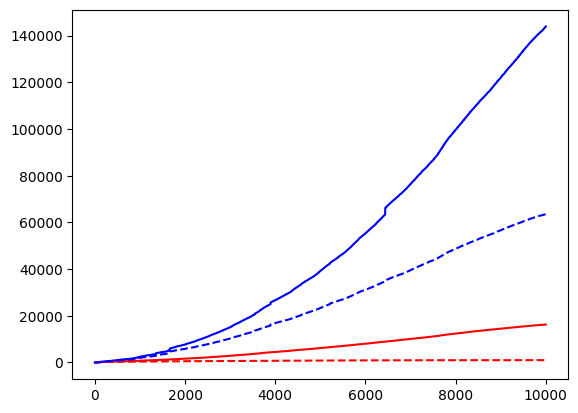

In [19]:
plt.plot(
    range(bin_cnt), cumulative_indiv, 'r-',
    range(bin_cnt), cumulative_pair, 'b-',
    range(bin_cnt), cumulative_indiv_filtered, 'r--',
    range(bin_cnt), cumulative_pair_filtered, 'b--',
)

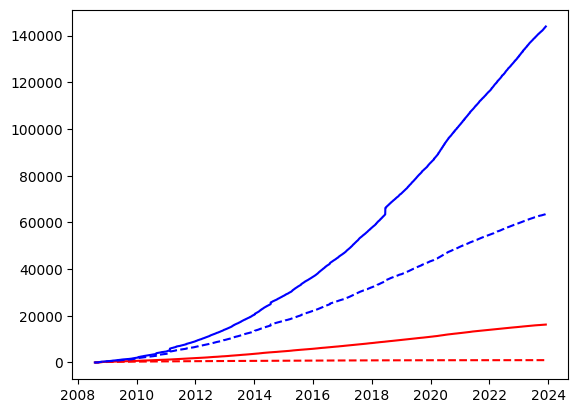

In [21]:
plt.plot(
    sorted(items.keys()), cumulative_indiv, 'r-',
    sorted(items.keys()), cumulative_pair, 'b-',
    sorted(items_filtered.keys()), cumulative_indiv_filtered, 'r--',
    sorted(items_filtered.keys()), cumulative_pair_filtered, 'b--',
)

In [23]:
sorted(items.keys())[:10], sorted(items_filtered.keys())[:10]

([Timestamp('2008-07-31 11:31:12'),
  Timestamp('2008-08-03 20:09:36'),
  Timestamp('2008-08-04 09:36:00'),
  Timestamp('2008-08-04 23:02:24'),
  Timestamp('2008-08-05 12:28:48'),
  Timestamp('2008-08-06 01:55:12'),
  Timestamp('2008-08-06 15:21:36'),
  Timestamp('2008-08-07 04:48:00'),
  Timestamp('2008-08-07 18:14:24'),
  Timestamp('2008-08-08 07:40:48')],
 [Timestamp('2008-07-31 11:31:50.880000'),
  Timestamp('2008-08-03 20:09:23.040000'),
  Timestamp('2008-08-04 09:35:38.400000'),
  Timestamp('2008-08-04 23:01:53.760000'),
  Timestamp('2008-08-05 12:28:09.120000'),
  Timestamp('2008-08-06 01:54:24.480000'),
  Timestamp('2008-08-06 15:20:39.840000'),
  Timestamp('2008-08-07 04:46:55.200000'),
  Timestamp('2008-08-07 18:13:10.560000'),
  Timestamp('2008-08-08 07:39:25.920000')])

In [55]:
libs_by_count

Counter({'numpy': 213741,
         'pandas': 176657,
         'os': 122066,
         'matplotlib': 100730,
         'sys': 97343,
         'time': 91017,
         're': 73984,
         'requests': 68007,
         'random': 64102,
         'datetime': 57757,
         'json': 49246,
         'bs4': 46917,
         'tkinter': 45455,
         'itertools': 41027,
         'selenium': 37646,
         'collections': 37421,
         'csv': 37159,
         'scipy': 30689,
         'sklearn': 29292,
         'cv2': 27867,
         'math': 27314,
         'subprocess': 25760,
         'urllib': 23324,
         'tensorflow': 22311,
         'PIL': 20948,
         'threading': 20712,
         'multiprocessing': 18791,
         'logging': 15658,
         'io': 15375,
         'pygame': 14420,
         'socket': 13796,
         'PyQt5': 13528,
         'functools': 13282,
         'glob': 13058,
         'typing': 11759,
         '__future__': 11393,
         'string': 11374,
         'seaborn': 1110

In [62]:
len({k:v for k, v in libs_by_count.items() if v > 20})

2032

In [57]:
len(libs_by_count)

16239